# Customer Churn - Binary Classification

# Contexto

---
Contamos con una base de datos de una compañía de telecomunicaciones, con la que la
misma podrá tomar acciones dirigidas en la retención de clientes propensos a la fuga.

La base de datos cuenta con 12 atributos regresores más la etiqueta de clase, que son:

* **Call Failures**: Número de fallos de llamadas
* **Complaints**: Quejas (1) o ninguna queja (0)
* **Subscription** Length: Meses totales de suscripción
* **Charge Amount**: Importe del cargo, atributo ordinal (0: importe más bajo, 9: importe más
alto)
* **Seconds of Use**: Segundos totales de llamadas
* **Frequency of use**: Número total de llamadas
* **Frequency of SMS**: Número total de mensajes de texto
* **Distinct Called Numbers**: Número total de llamadas distintas
* **Age Group**: Grupo de edad, atributo ordinal (1: menor edad, 5: mayor edad)
* **Tariff Plan**: Plan de tarifa, binario (1: pago por uso, 2: contractual)
* **Status**: Estado, binario (1: activo, 2: inactivo)
* **Churn**: Renuncia, binario (1: cancelación, 0: no cancelación) - Etiqueta de clase
* **Customer Value**: El valor calculado del cliente

# Punto 1

---

Importar Tensorflow con Keras junto con base de datos


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [2]:
df = pd.read_csv("Customer Churn.csv")
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


Preprocesamiento de datos

In [3]:
def data_quality_analysis(df):
    # Crear un nuevo dataframe para almacenar los resultados
    result_df = pd.DataFrame(columns=['Column', 'Type', 'Unique', 'Missing'])

    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

    result_df['Column'] = columns
    result_df['Type'] = data_types
    result_df['Unique'] = unique_values
    result_df['Missing'] = missing_values

    return result_df

In [4]:
analysis_result = data_quality_analysis(df)
analysis_result

,Column,Type,Unique,Missing
0,Call Failure,int64,37,0
1,Complains,int64,2,0
2,Subscription Length,int64,45,0
3,Charge Amount,int64,11,0
4,Seconds of Use,int64,1756,0
5,Frequency of use,int64,242,0
6,Frequency of SMS,int64,405,0
7,Distinct Called Numbers,int64,92,0
8,Age Group,int64,5,0
9,Tariff Plan,int64,2,0


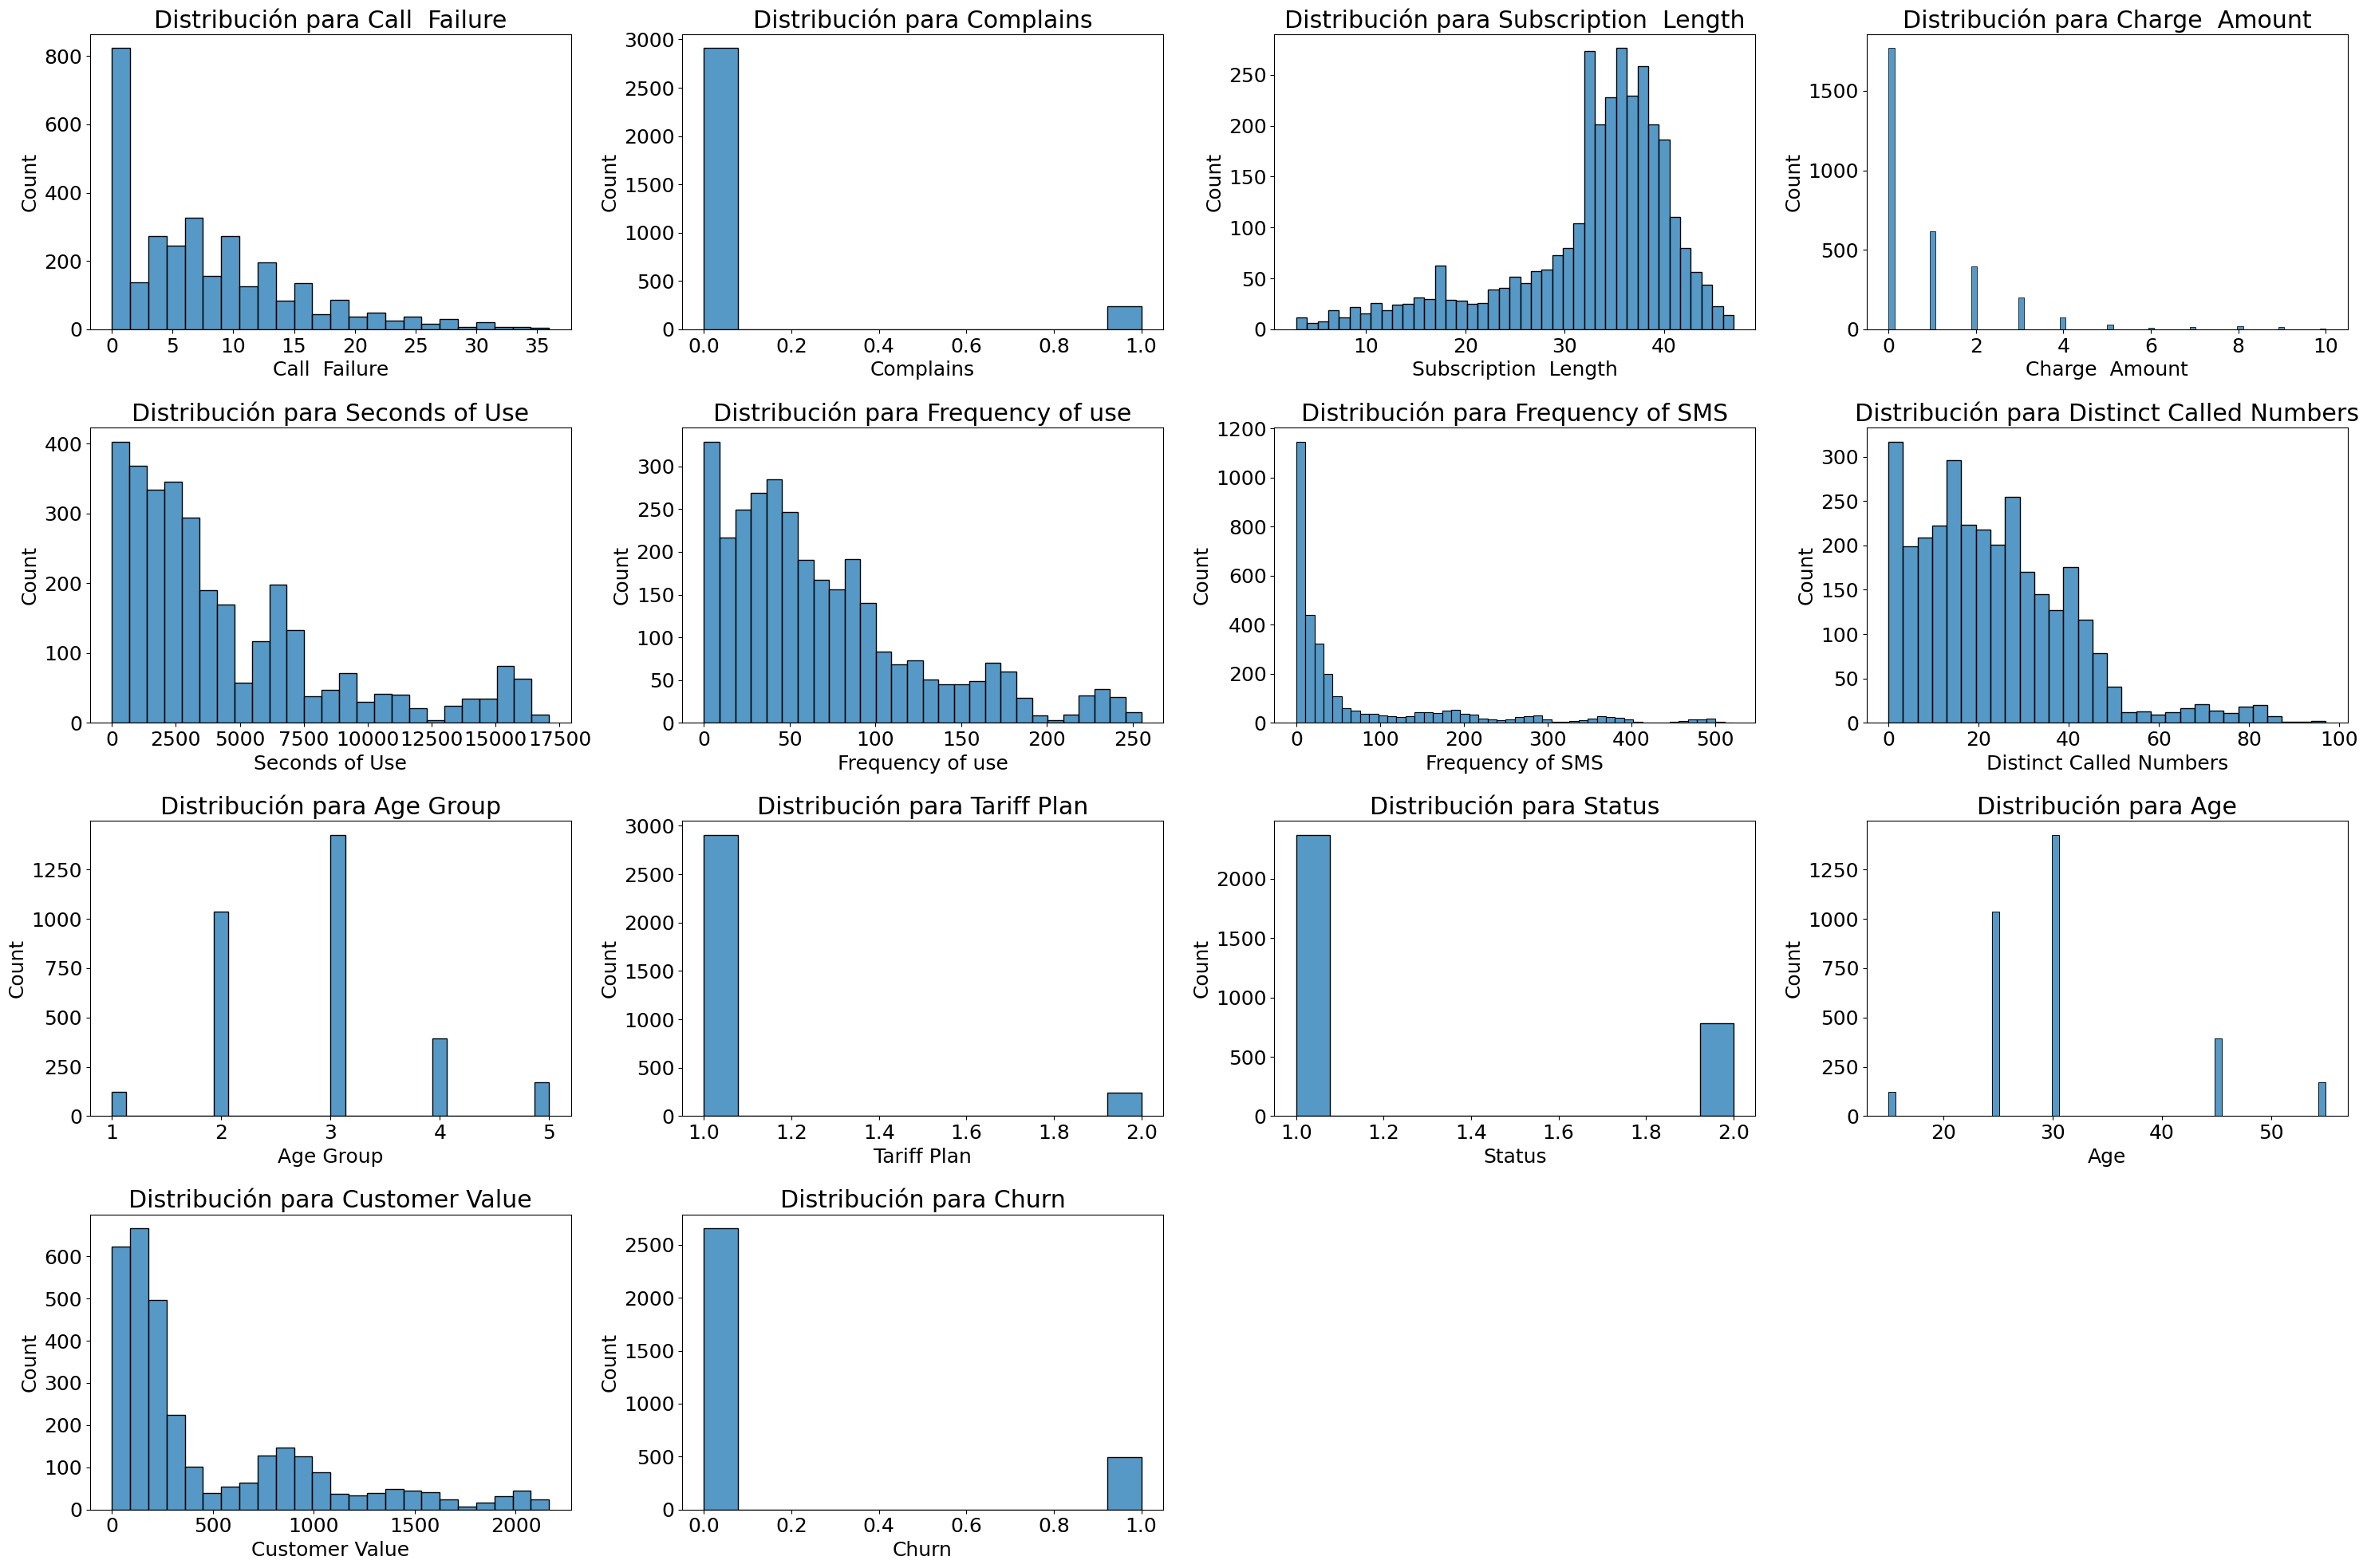

In [5]:
plt.rcParams.update({'font.size': 18})
num_cols = len(df.columns)
rows = (num_cols // 4) + (num_cols % 4 > 0)  # Calcula el número de filas necesarias

plt.figure(figsize=(30, 5 * rows))  # Ajusta la altura de la figura dinámicamente
for n, i in enumerate(list(df.columns)):
    plt.subplot(rows, 4, n + 1)
    # Get the row index from analysis_result where 'Column' matches the current column name
    row_index = analysis_result[analysis_result['Column'] == i].index[0]

    # Access the 'Type' using the row index
    if analysis_result.loc[row_index, 'Type']=='object':
        sns.countplot(y= df[i], order=df[i].value_counts().iloc[:7].index)
        plt.title('Frecuencias para {}'.format(i))

    else:
        sns.histplot(df[i])
        plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

# Punto 2

---

Subscription Length

In [6]:
def histogramas_en_grid(df, columna_target, columnas_por_fila=4):
    """
    Muestra histogramas con línea de distribución KDE para cada columna numérica en un solo gráfico tipo grid.

    Parámetros:
    - df: DataFrame con los datos
    - columna_target: str, nombre de la columna de segmentación (target)
    - columnas_por_fila: int, número de columnas por fila en la grilla de subplots
    """
    columnas_numericas = df.select_dtypes(include=['number']).columns.drop(columna_target, errors='ignore')
    total = len(columnas_numericas)
    filas = int(np.ceil(total / columnas_por_fila))

    fig, axes = plt.subplots(filas, columnas_por_fila, figsize=(5 * columnas_por_fila, 4 * filas))
    axes = axes.flatten()  # Para indexar fácilmente

    for i, col in enumerate(columnas_numericas):
        sns.histplot(
            data=df,
            x=col,
            hue=columna_target,
            kde=True,
            stat="density",
            common_norm=False,
            element="step",
            palette="tab10",
            ax=axes[i]
        )
        axes[i].set_title(f'{col}')
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Densidad')
        axes[i].grid(True)

    # Elimina ejes vacíos si hay más subplots que columnas numéricas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


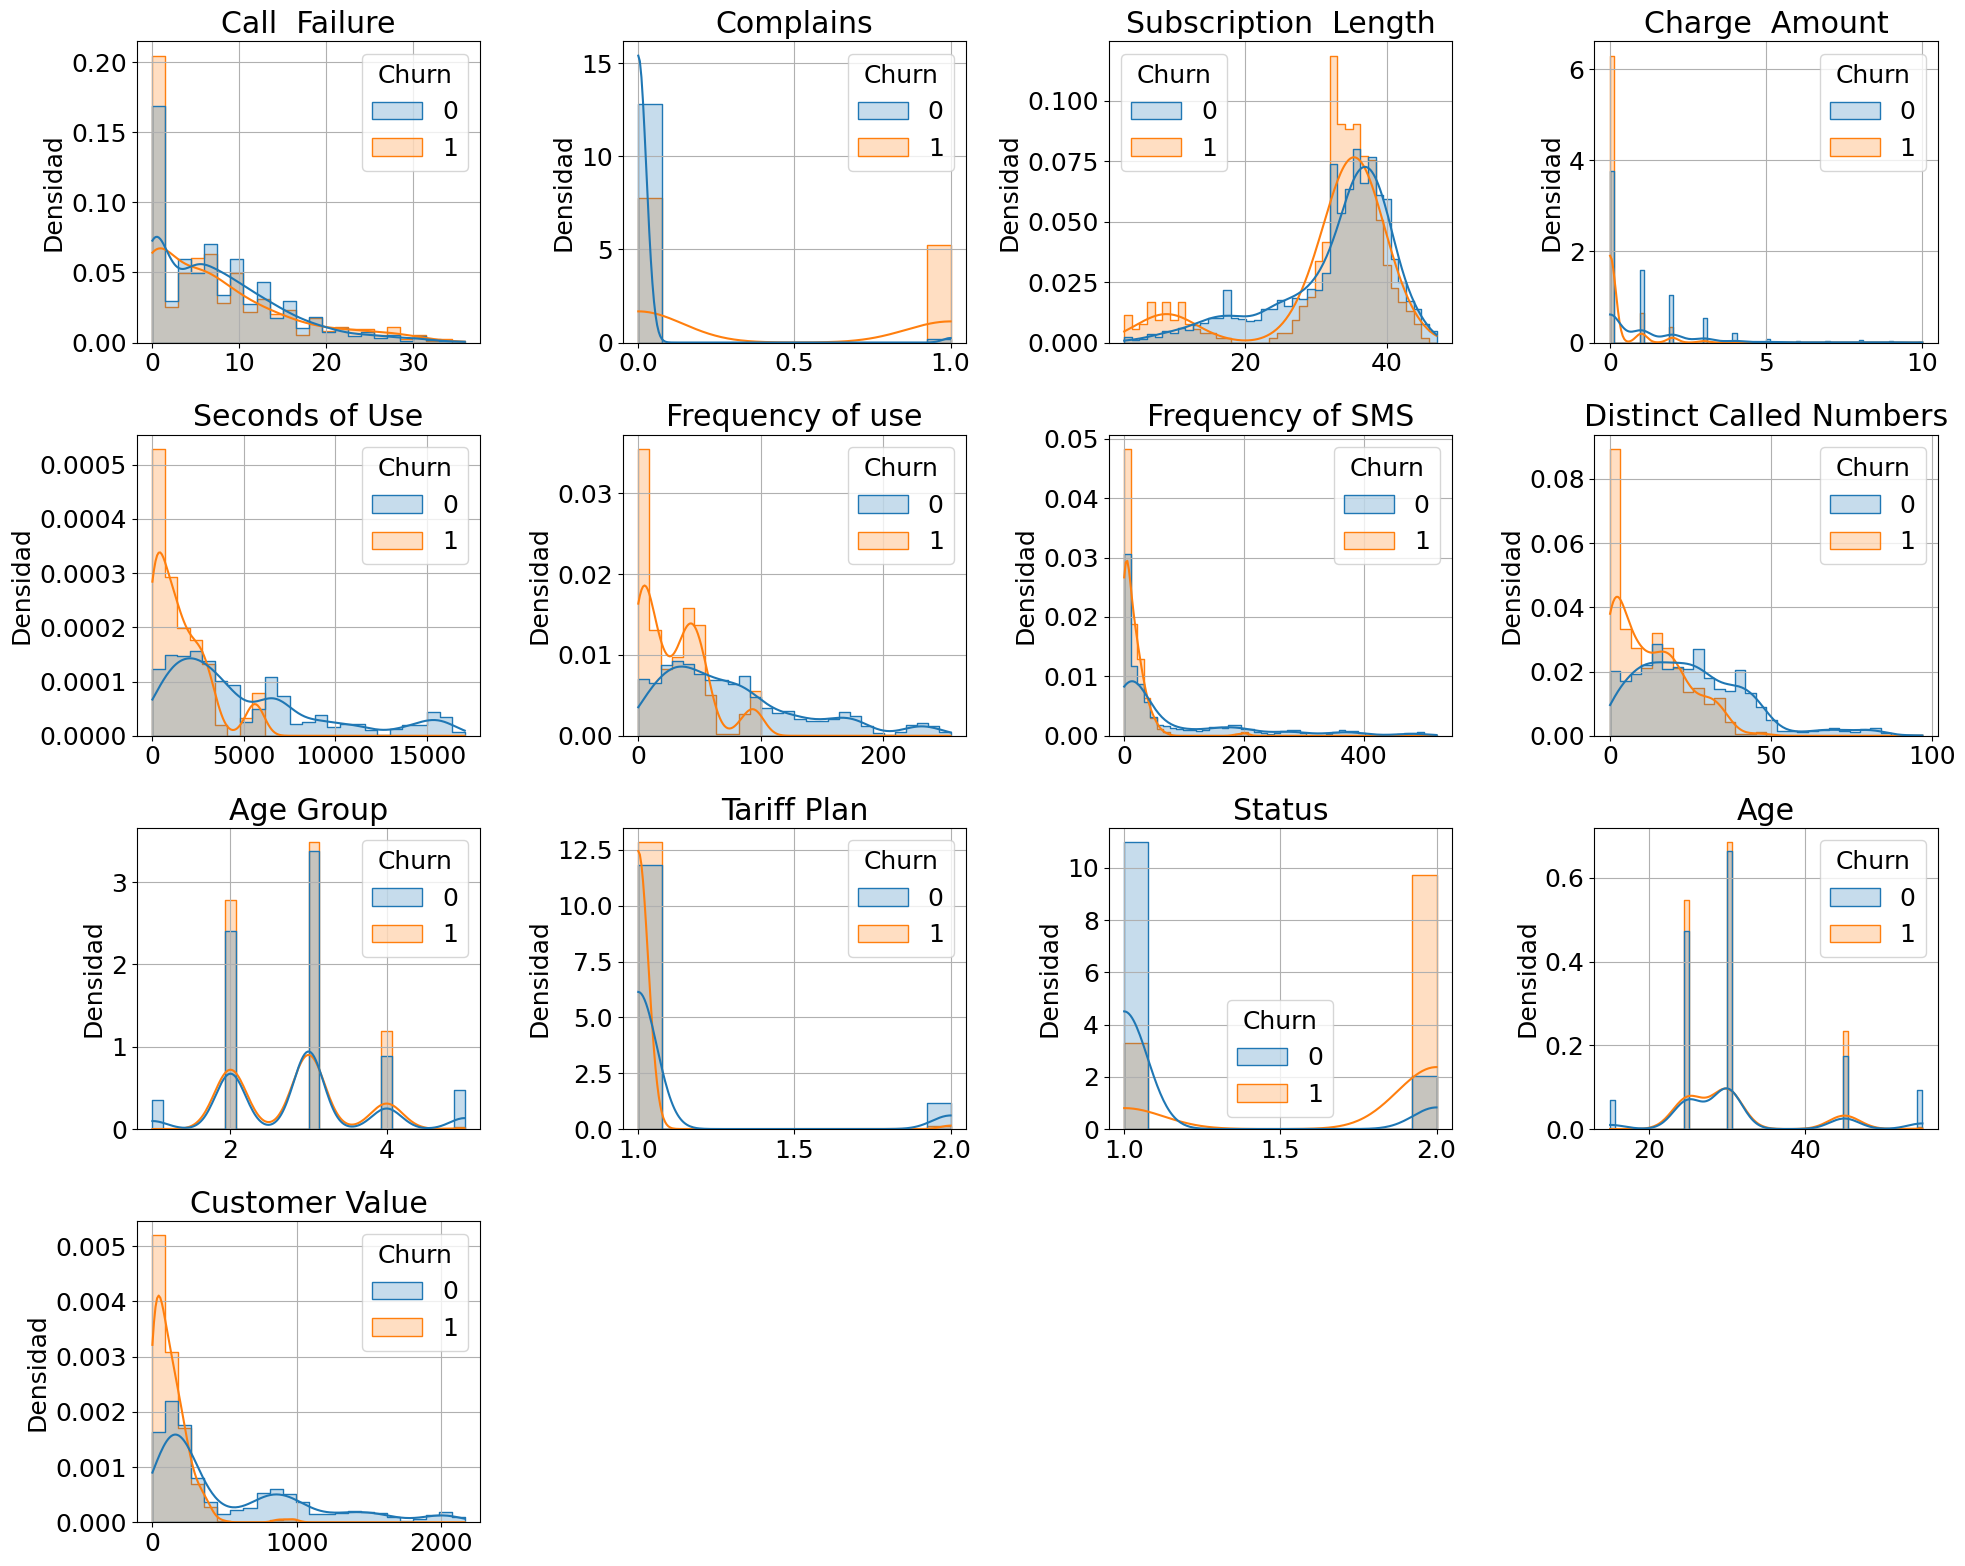

In [7]:
histogramas_en_grid(df,'Churn')

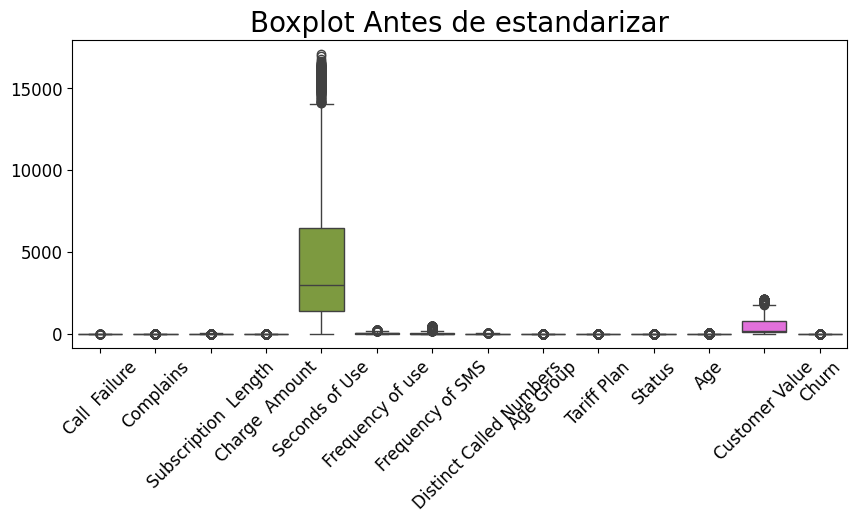

In [8]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=df)
plt.title('Boxplot Antes de estandarizar',fontsize=20)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

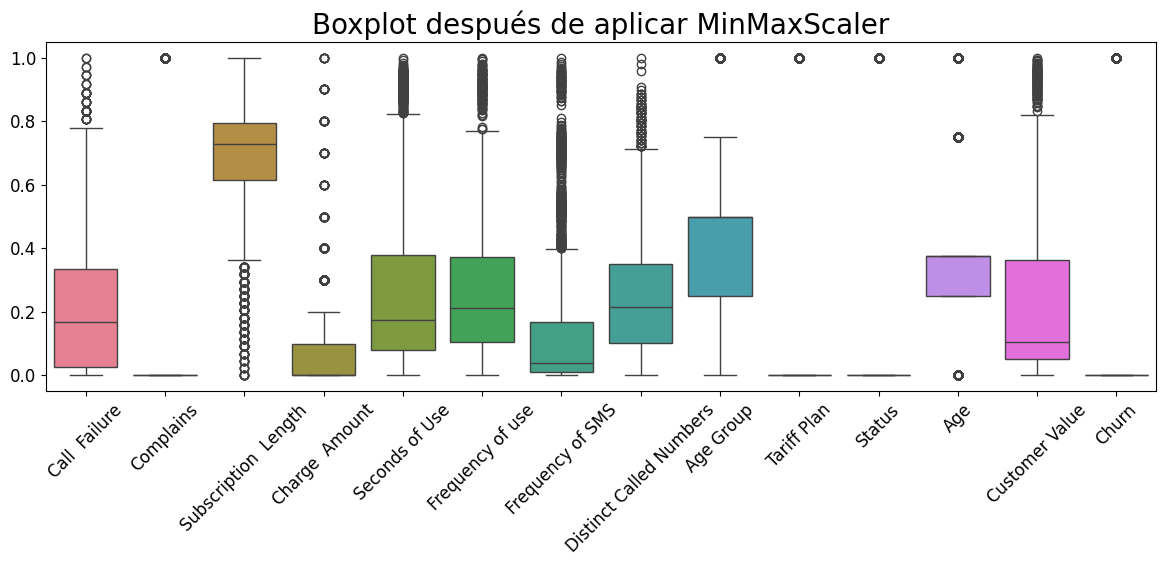

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Boxplot después de aplicar MinMaxScaler', fontsize=20)
plt.tight_layout()
plt.show()

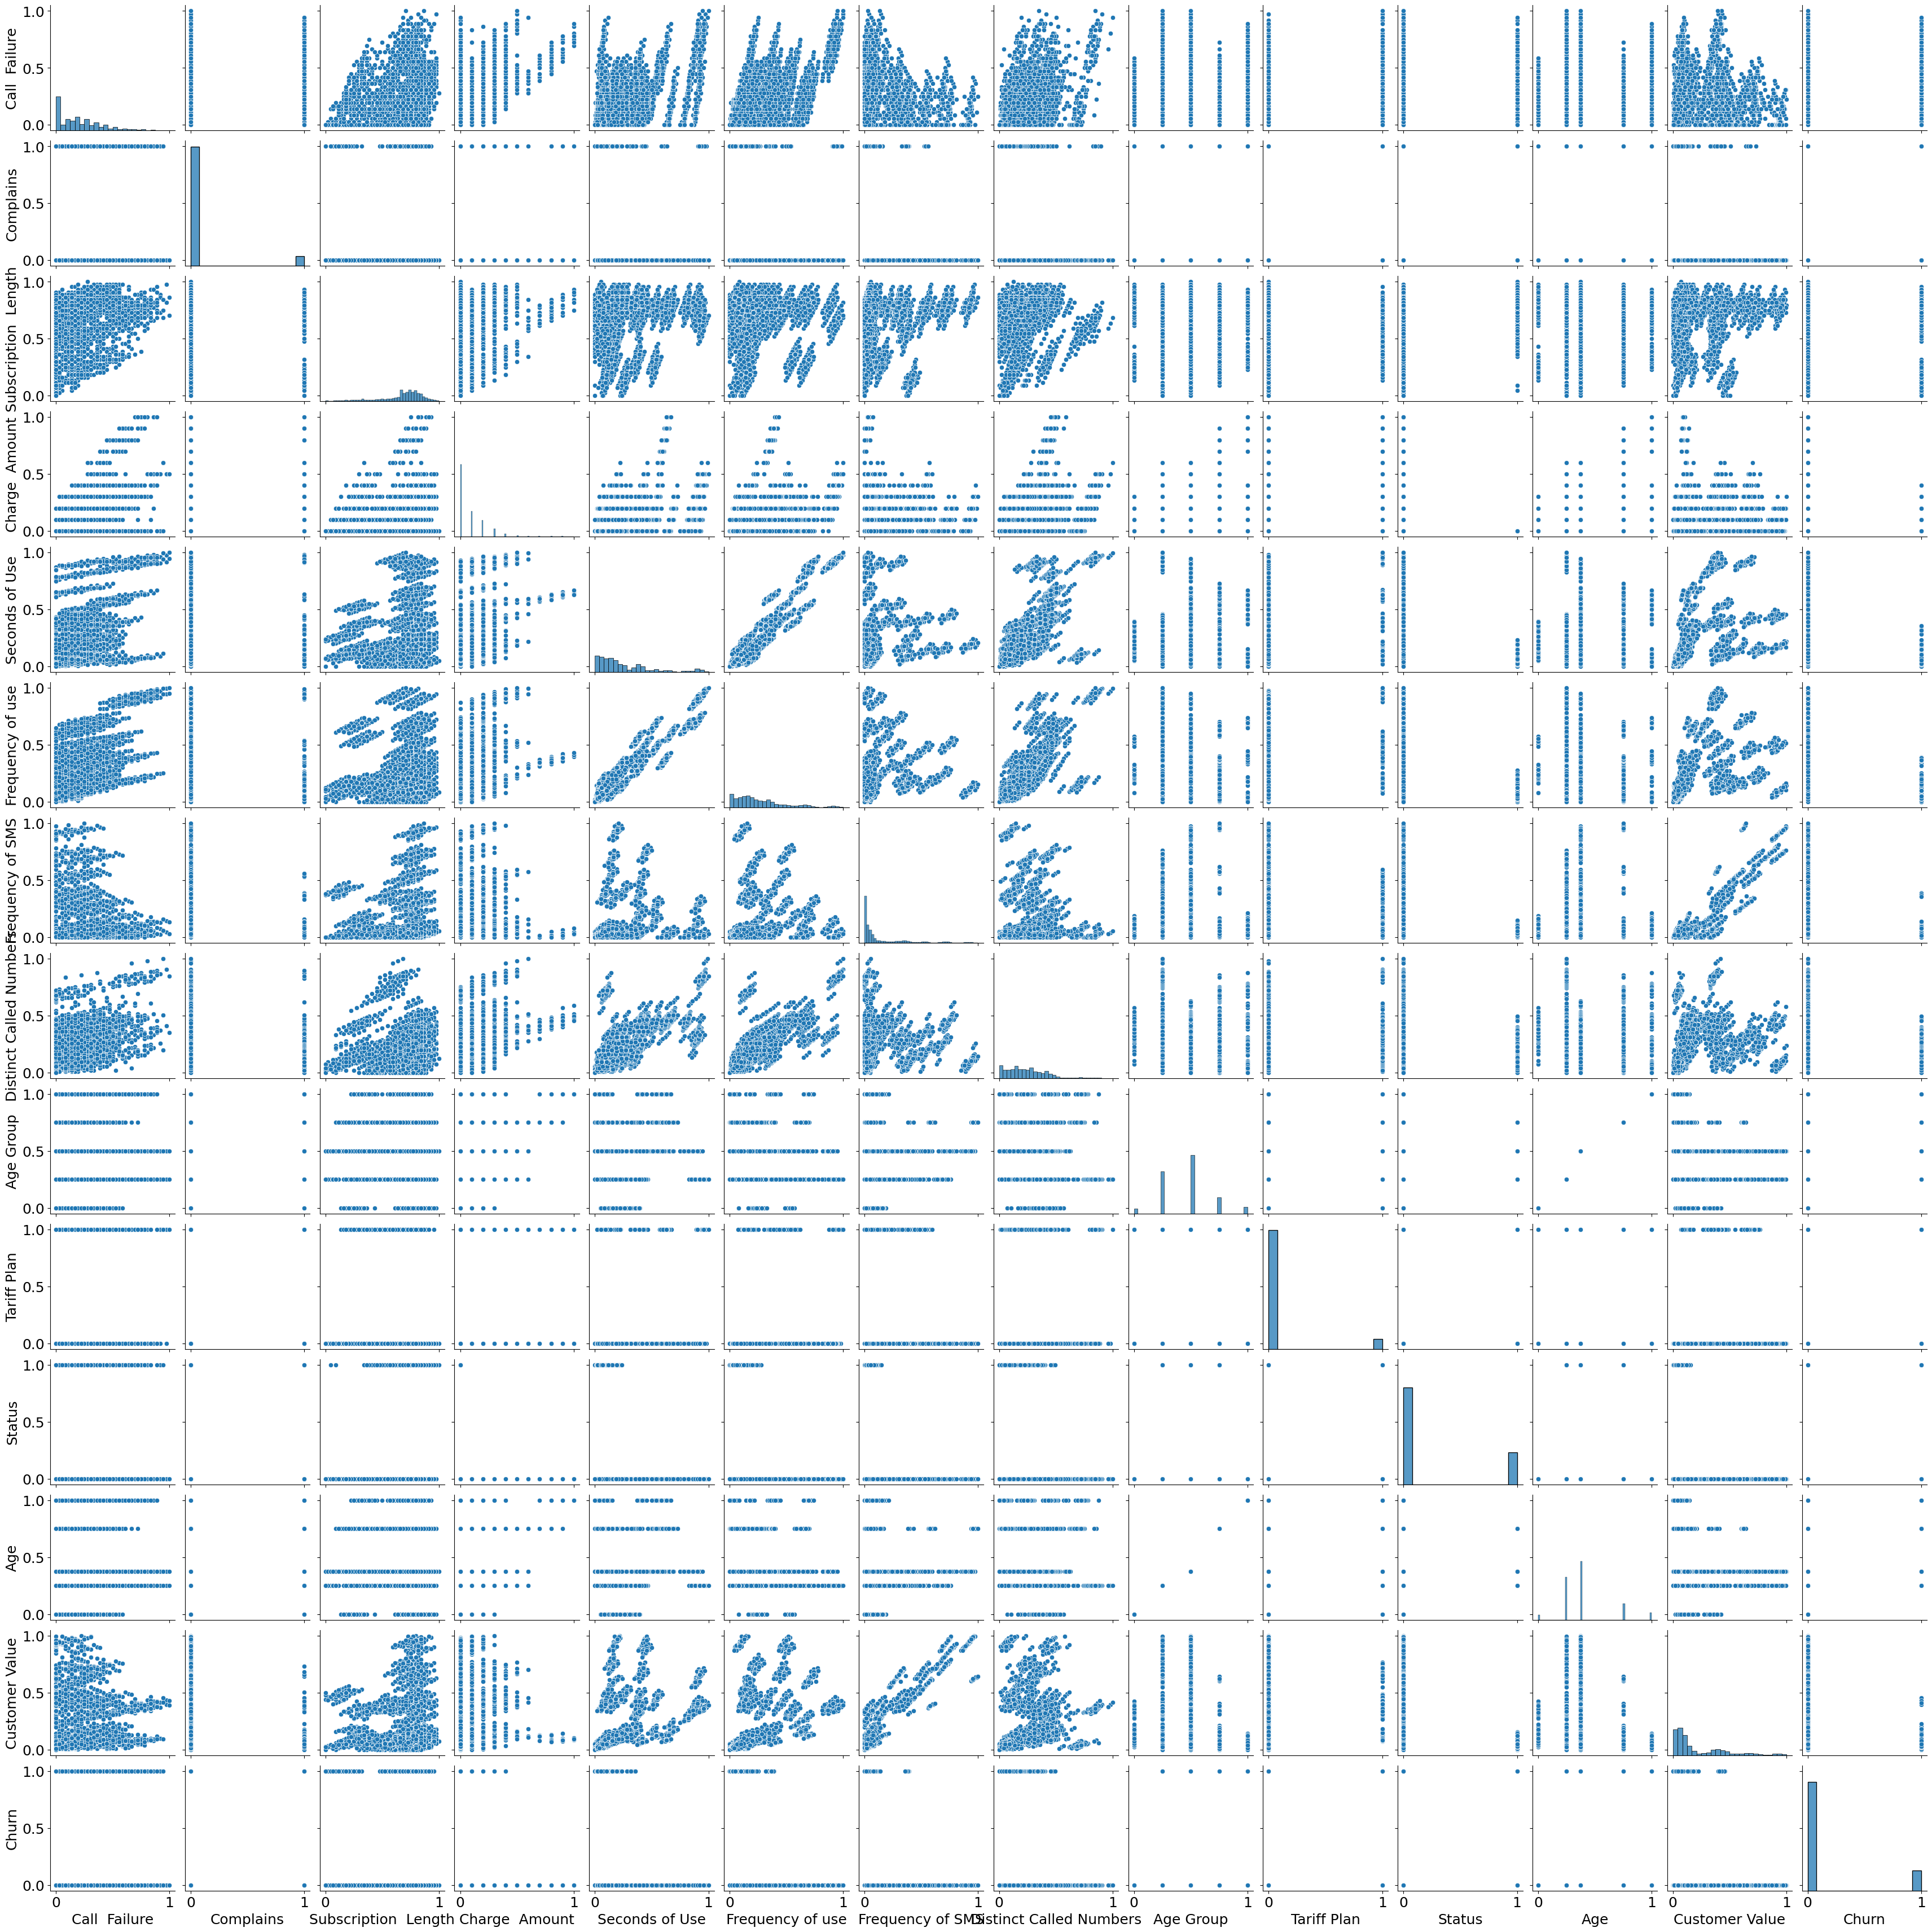

In [10]:
sns.pairplot(df_scaled)

<Axes: >

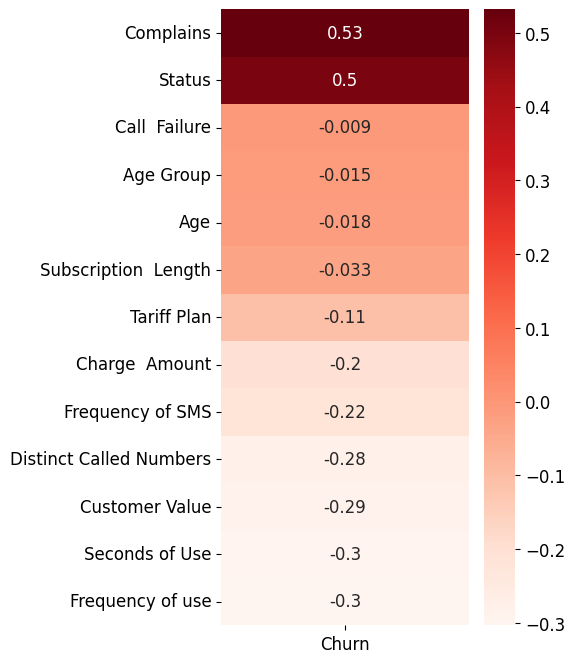

In [11]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(4, 8))
sns.heatmap(df_scaled.loc[:, df_scaled.columns].corr().loc[:, ['Churn']].sort_values('Churn', ascending=False).iloc[1:], cmap='Reds', annot=True)

# Punto 3

---

balanceo de clase usando SMOTE

In [12]:
df_scaled['Churn'].value_counts()

,count
Churn,
0.0,2655
1.0,495


In [13]:
X = df_scaled.drop('Churn', axis=1)
y = df_scaled['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Mostrar nuevo balance de clases
print("Distribución original:", y_train.value_counts())
print("Después de SMOTE:", pd.Series(y_resampled).value_counts())

Distribución original: Churn
0.0    1778
1.0     332
Name: count, dtype: int64
Después de SMOTE: Churn
0.0    1778
1.0    1778
Name: count, dtype: int64


# Punto 4

---

RandomForest con hiper parámetros por defecto

Reporte de clasificación (F1-Score por clase):
              precision    recall  f1-score   support

         0.0     0.9849    0.9647    0.9747       877
         1.0     0.8287    0.9202    0.8721       163

    accuracy                         0.9577      1040
   macro avg     0.9068    0.9424    0.9234      1040
weighted avg     0.9604    0.9577    0.9586      1040



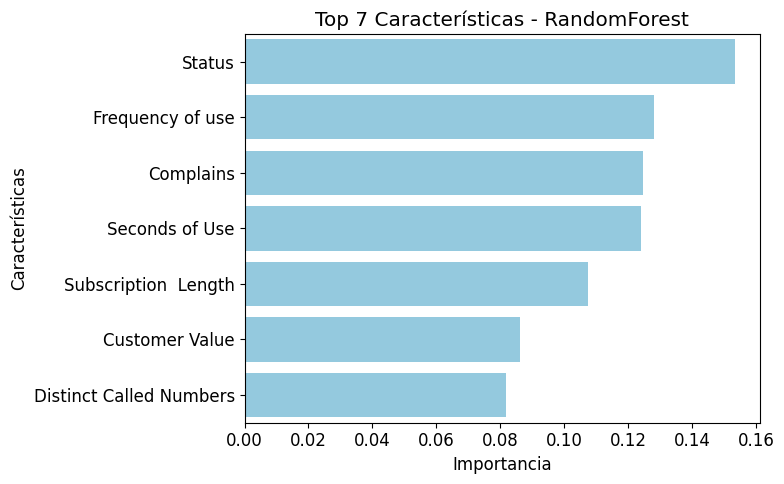

In [14]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)

# 3. F1-Score para ambas clases
print("Reporte de clasificación (F1-Score por clase):")
print(classification_report(y_test, y_pred, digits=4))

# 4. Importancia de características
importancias = pd.Series(rf.feature_importances_, index=X.columns)
importantes = importancias.sort_values(ascending=False).head(7)

# 5. Graficar las 7 características más importantes
plt.figure(figsize=(8, 5))
sns.barplot(x=importantes.values, y=importantes.index, color='skyblue')
plt.title('Top 7 Características - RandomForest')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

# Punto 5

---

1. filtra el conjunto de entrenamiento Usando las siete características
2. entrena un modelo de red neuronal feedforward con una capa
oculta.
3. Ajustar manualmente:
función de activación, cantidad de neuronas, learning_rate y  cantidad de épocas
4. Optimizador =  Descenso del Gradiente Estocástico.

Los ajustes manuales de los hiper parámetros deben ser tales que la métrica AUC sea mayor al 90%. Muestra finalmente ROC y su AUC.

In [15]:
X_resampled_filtered = X_resampled[importantes.index].copy()
X_resampled_filtered.tail(5)

,Status,Frequency of use,Complains,Seconds of Use,Subscription Length,Customer Value,Distinct Called Numbers
3551,0.0,0.043080,1.0,0.039894,0.755434,0.024646,0.056626
3552,0.0,0.046729,0.0,0.077742,0.075988,0.024764,0.026520
3553,1.0,0.136938,0.0,0.030197,0.576905,0.014642,0.114964
3554,1.0,0.000000,0.0,0.000000,0.727273,0.000000,0.000000
3555,1.0,0.148599,1.0,0.163257,0.678301,0.052242,0.146539


In [16]:
# creamos un modelo Secuencial
model_ann = Sequential()

# agregamos la capa de entrada
model_ann.add(keras.Input(shape=(7,)))

# agregamos el perceptrón considerando un Bias
# y una función de activación lineal
model_ann.add(
    Dense(
        units=80,
        activation='relu',
        use_bias=True
    )
)
model_ann.add(
    Dense(
        units=1,
        activation='sigmoid',
        use_bias=True
    )
)

model_ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721 (2.82 KB)

 Trainable params: 721 (2.82 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_ann.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy')
model_ann.fit(X_resampled_filtered, y_resampled, epochs=200, verbose=0)

In [18]:
# creamos un modelo Secuencial
model_ann2 = Sequential()

# agregamos la capa de entrada
model_ann2.add(keras.Input(shape=(13,)))

# agregamos el perceptrón considerando un Bias
# y una función de activación lineal
model_ann2.add(
    Dense(
        units=80,
        activation='relu',
        use_bias=True
    )
)
model_ann2.add(
    Dense(
        units=1,
        activation='sigmoid',
        use_bias=True
    )
)

model_ann2.summary()
model_ann2.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy')
model_ann2.fit(X_resampled, y_resampled, epochs=200, verbose=0)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 80)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,201 (4.69 KB)

 Trainable params: 1,201 (4.69 KB)

 Non-trainable params: 0 (0.00 B)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


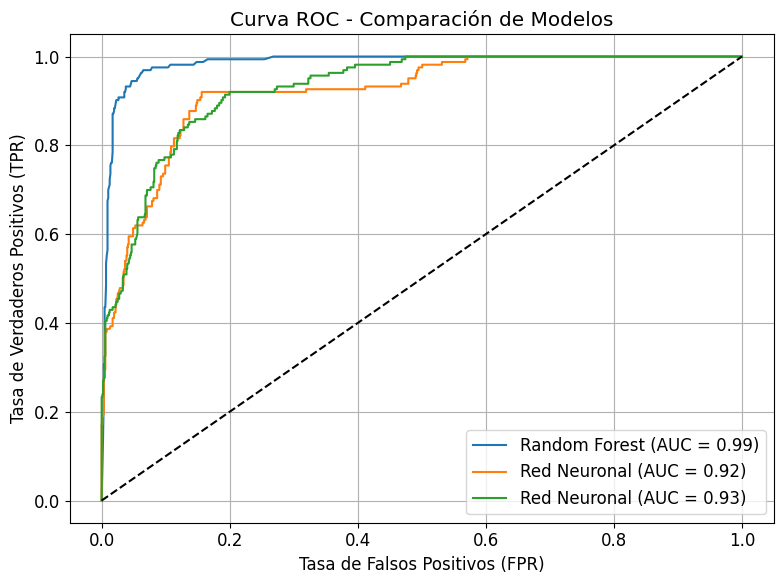

In [21]:
y_score_rf = rf.predict_proba(X_test)[:, 1]  # Random Forest
y_score_ann = model_ann.predict(X_test[importantes.index]).ravel()
y_score_ann2 = model_ann2.predict(X_test).ravel()

# Calcular curvas ROC y AUC
fpr1, tpr1, _ = roc_curve(y_test, y_score_rf)
fpr2, tpr2, _ = roc_curve(y_test, y_score_ann)
fpr3, tpr3, _ = roc_curve(y_test, y_score_ann2)


auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)

# Graficar ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Random Forest (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'Red Neuronal (AUC = {auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'Red Neuronal (AUC = {auc3:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

A continuacion se muestra el desempeño de la red neuronal sin filtrar el dataset con los "Important Features"